<font size="4">Набор данных: количество арендованных велосипедов общего пользования (https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from ucimlrepo import fetch_ucirepo 

### Самостоятельно реализовать функцию gradient_descent(X, y)

In [2]:
def gradient_descent(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    for _ in range(epochs):
        y_pred = np.dot(X, weights) + bias
        dw = -2/m * np.dot(X.T, (y - y_pred))
        db = -2/m * np.sum(y - y_pred)
        weights -= lr * dw
        bias -= lr * db
    return weights, bias

### Найти данные, на которых интересно будет решать задачу регрессии. 

In [3]:
bike_sharing = fetch_ucirepo(id=275)

In [4]:
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

### Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).

In [5]:
df = pd.DataFrame(X)
df['target'] = y
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,target
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [6]:
bike_sharing.variables

,name,role,type,demographic,description,units,missing_values
0,instant,ID,Integer,None,record index,None,no
1,dteday,Feature,Date,None,date,None,no
2,season,Feature,Categorical,None,"1:winter, 2:spring, 3:summer, 4:fall",None,no
3,yr,Feature,Categorical,None,"year (0: 2011, 1: 2012)",None,no
4,mnth,Feature,Categorical,None,month (1 to 12),None,no
5,hr,Feature,Categorical,None,hour (0 to 23),None,no
6,holiday,Feature,Binary,None,weather day is holiday or not (extracted from ...,None,no
7,weekday,Feature,Categorical,None,day of the week,None,no
8,workingday,Feature,Binary,None,"if day is neither weekend nor holiday is 1, ot...",None,no
9,weathersit,Feature,Categorical,None,"- 1: Clear, Few clouds, Partly cloudy, Partly ...",None,no


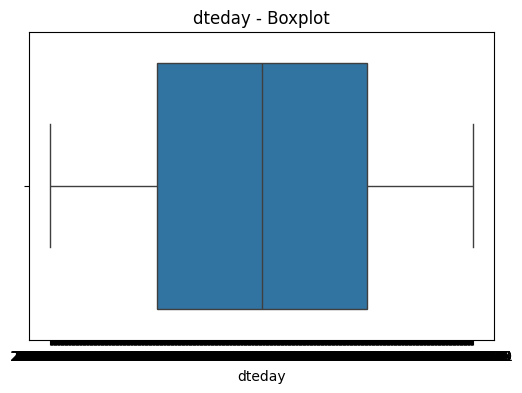

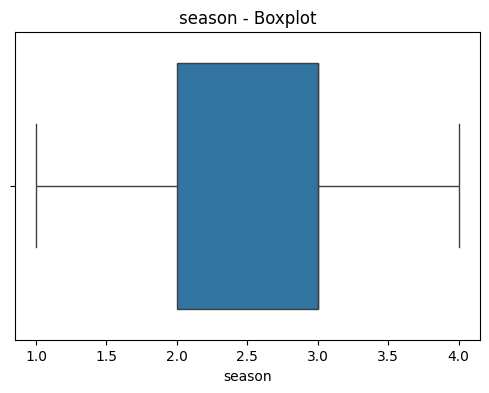

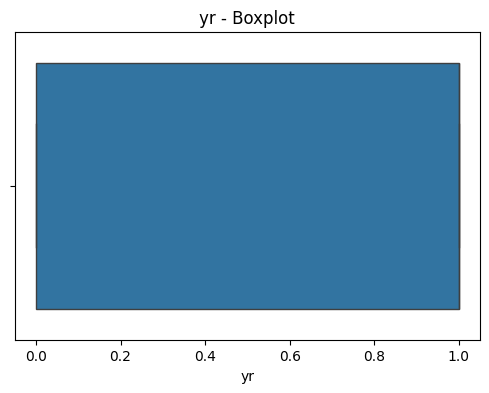

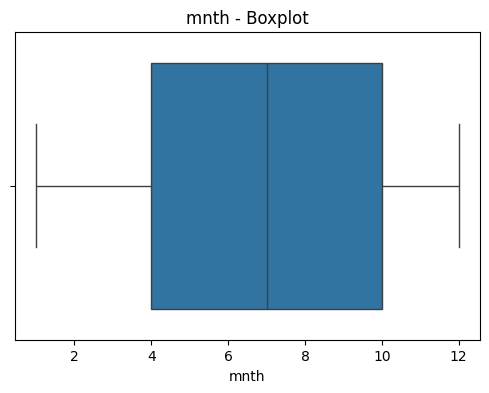

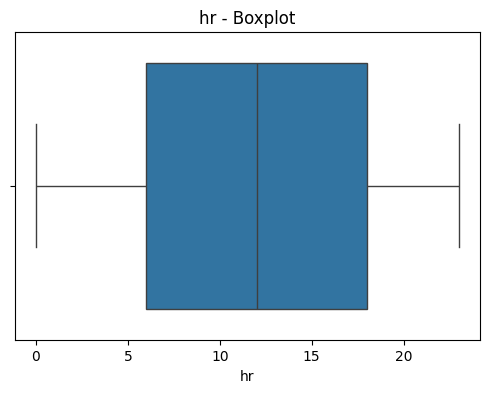

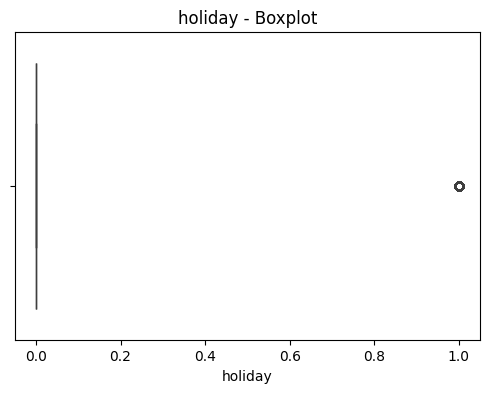

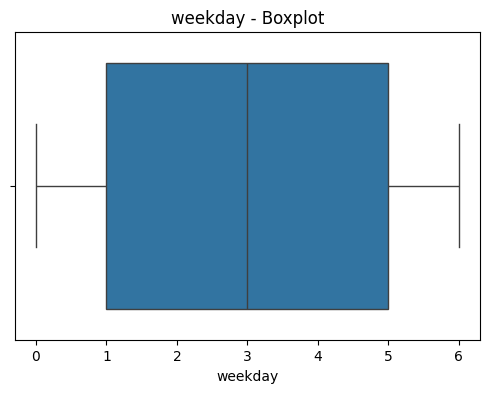

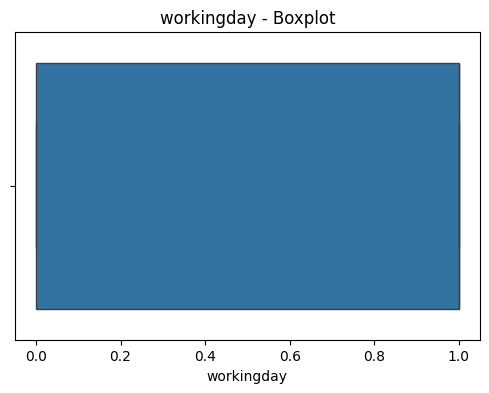

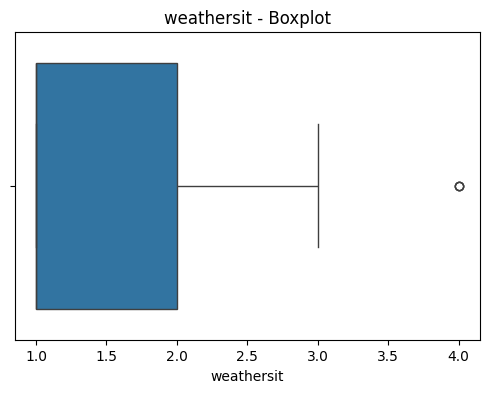

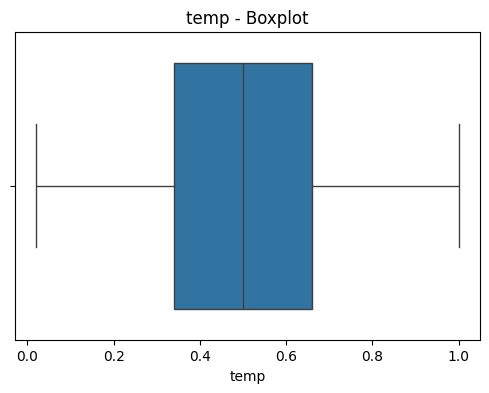

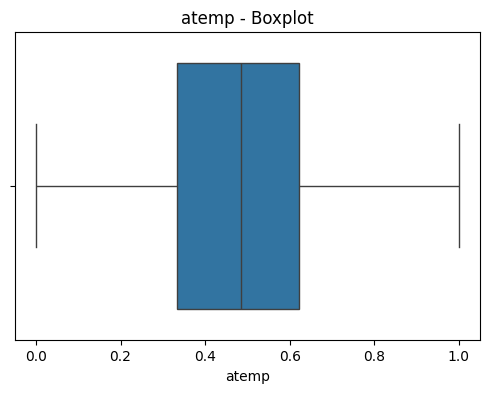

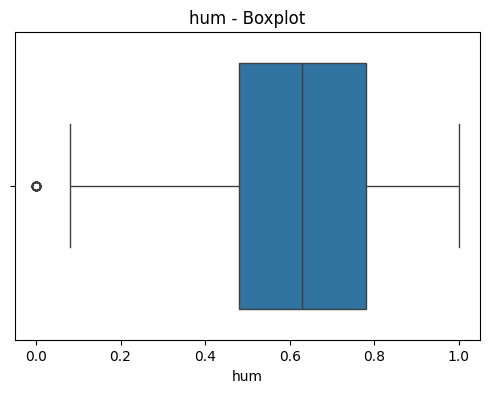

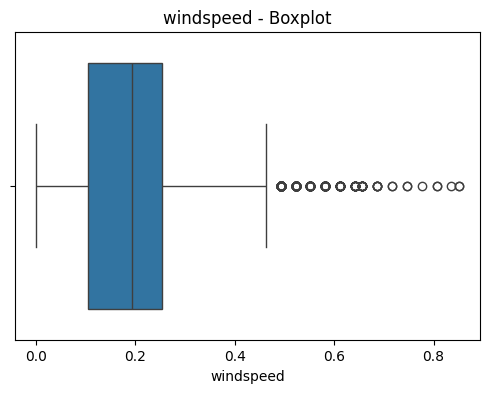

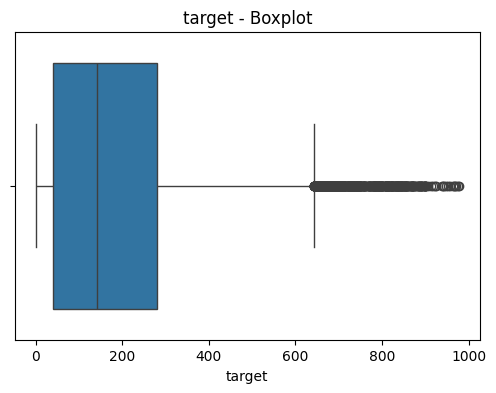

In [7]:
for column in df.columns:  
    plt.figure(figsize=(6,4))  
    sns.boxplot(x=df[column])  
    plt.title(f"{column} - Boxplot")  
    plt.show()  

In [8]:
print(df.shape)
print(df.describe())

(17379, 14)
             season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465431      

In [9]:
# data cleaning

In [10]:
for column in df.columns:
    if df[column].dtype != 'object': 
        Q1 = df[column].quantile(0.25) 
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(df.shape)
print(df.describe())

(16042, 14)
             season            yr          mnth            hr  holiday  \
count  16042.000000  16042.000000  16042.000000  16042.000000  16042.0   
mean       2.507543      0.487408      6.539397     11.414599      0.0   
std        1.104580      0.499857      3.434276      6.980713      0.0   
min        1.000000      0.000000      1.000000      0.000000      0.0   
25%        2.000000      0.000000      4.000000      5.000000      0.0   
50%        3.000000      0.000000      7.000000     11.000000      0.0   
75%        3.000000      1.000000     10.000000     17.750000      0.0   
max        4.000000      1.000000     12.000000     23.000000      0.0   

            weekday    workingday    weathersit          temp         atemp  \
count  16042.000000  16042.000000  16042.000000  16042.000000  16042.000000   
mean       3.029049      0.699227      1.428937      0.495007      0.474502   
std        2.017634      0.458608      0.639469      0.192110      0.170985   
min  

In [11]:
df = df.drop(columns=['holiday'], errors='ignore')

### Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.

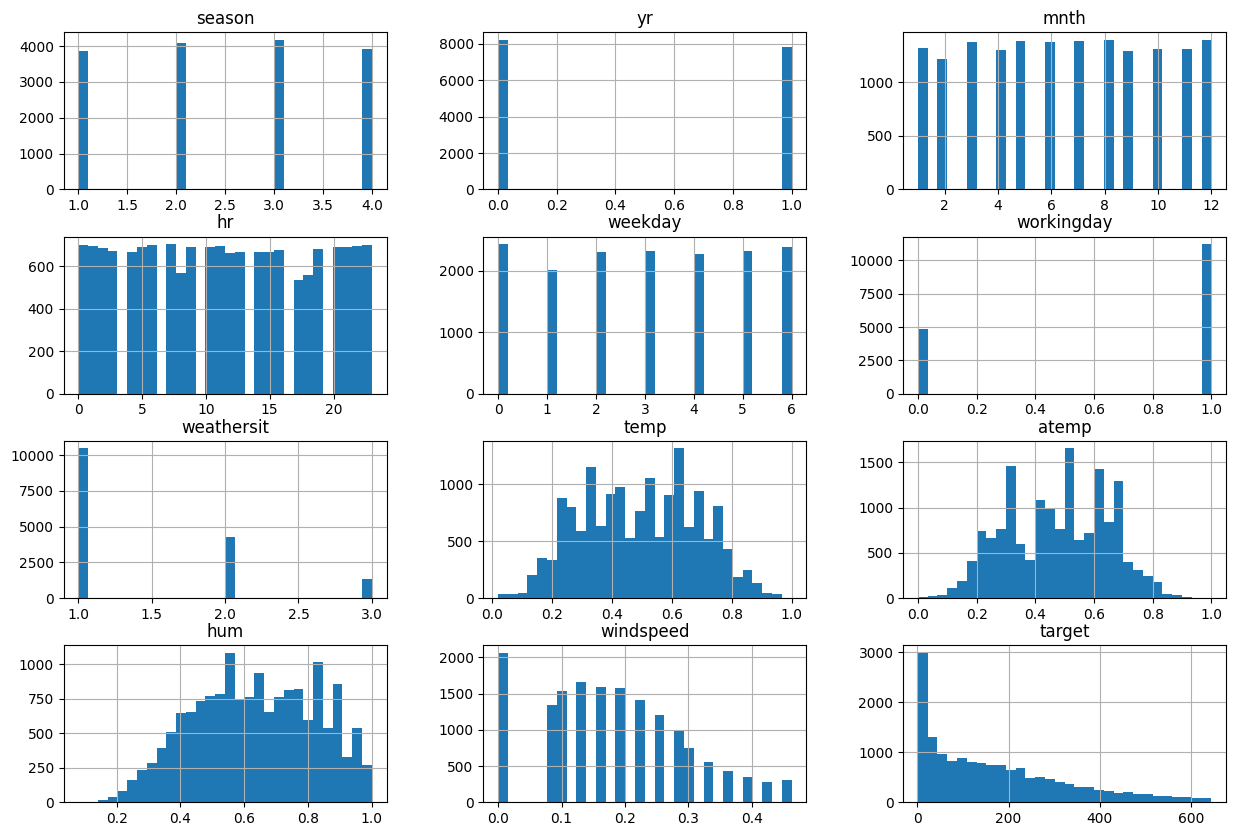

In [12]:
df.hist(bins=30, figsize=(15,10))  
plt.show() 

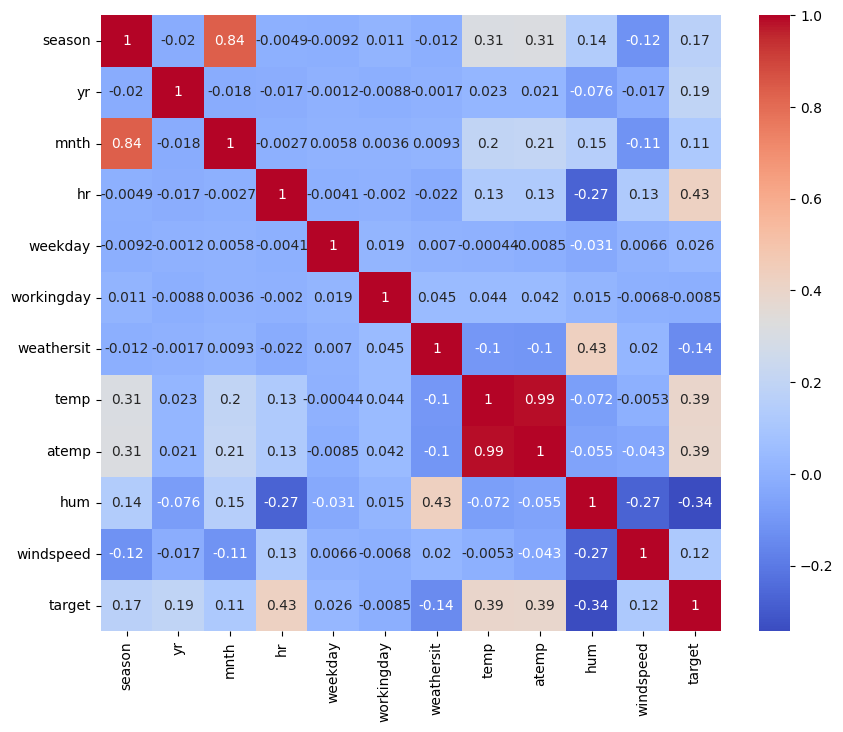

In [13]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))  
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')  
plt.show()  

существует зависимость между количеством аренд и temp, atemp, hum

### Feature Engineering

In [14]:
df_new = df.drop(['dteday','season','yr','mnth','weekday','workingday','weathersit','windspeed'],axis=1)

In [15]:
df_new

,hr,temp,atemp,hum,target
0,0,0.24,0.2879,0.81,16
1,1,0.22,0.2727,0.80,40
2,2,0.22,0.2727,0.80,32
3,3,0.24,0.2879,0.75,13
4,4,0.24,0.2879,0.75,1
...,...,...,...,...,...
17374,19,0.26,0.2576,0.60,119
17375,20,0.26,0.2576,0.60,89
17376,21,0.26,0.2576,0.60,90
17377,22,0.26,0.2727,0.56,61


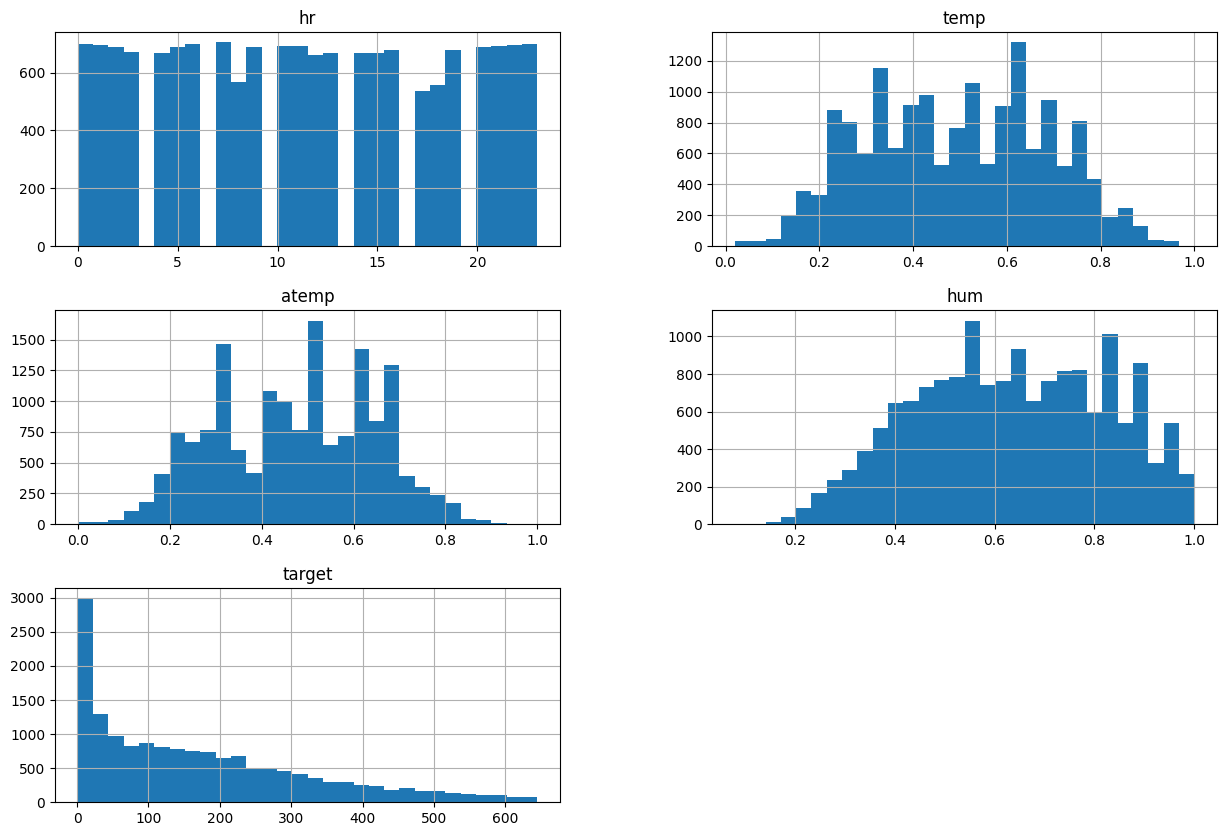

In [16]:
df_new.hist(bins=30, figsize=(15,10))  
plt.show()  

In [17]:
skewness = df_new.iloc[:,:-1].skew()
skewness

hr       0.028582
temp     0.003594
atemp   -0.073104
hum     -0.104048
dtype: float64

### Случайным образом разбить данные на обучающую и тестовую выборки

In [18]:
target_column = 'target'
X = df_new.drop(columns=[target_column])
y = df_new[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### При обучении моделей использовать масштабирование данных

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###  добавить возможность настройки нужных гиперпараметров, а в процессе обучения всех моделей осуществить подбор оптимальных значений этих гиперпараметров.

In [20]:
def predict(X, weights, bias):
    return np.dot(X, weights) + bias
    
param_grid = {
    'lr': [ 0.01, 0.1],
    'epochs': [500, 1000]
}

best_params = None
best_score = float('inf')

for lr in param_grid['lr']:
    for epochs in param_grid['epochs']:
        weights, bias = gradient_descent(X_train, y_train, lr=lr, epochs=epochs)
        y_val_pred = predict(X_test, weights, bias)
        mse = mean_squared_error(y_test, y_val_pred)
        if mse < best_score:
            best_score = mse
            best_params = {'lr': lr, 'epochs': epochs}

print(f"Оптимальные гиперпараметры: {best_params}, валидационные наборы MSE: {best_score:.4f}")

Оптимальные гиперпараметры: {'lr': 0.1, 'epochs': 500}, валидационные наборы MSE: 16041.1503


### Обучить модель на обучающей выборке, используя функцию gradient_descent(X, y).

In [21]:
weights, bias = gradient_descent(X_train, y_train, lr=best_params['lr'], epochs=best_params['epochs'])

### Оценить качество модели на обучающей и тестовой выборках, используя MSE, RMSE и R^2. 

In [22]:
y_train_pred = predict(X_train, weights, bias)
y_test_pred = predict(X_test, weights, bias)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Обучающие наборы MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R^2: {train_r2:.4f}")
print(f"тестовые наборы MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R^2: {test_r2:.4f}")

Обучающие наборы MSE: 15781.8277, RMSE: 125.6257, R^2: 0.3503
тестовые наборы MSE: 16041.1503, RMSE: 126.6537, R^2: 0.3453


### Обучить модель, используя существующую библиотеку. 

In [23]:
# используйте Ridge
ridge_param_grid = {'alpha': [0.1, 1, 10, 100]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, ridge_param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Оптимальные гиперпараметры
print(f"Ridge Оптимальные гиперпараметры: {grid_search.best_params_}")

ridge_best = grid_search.best_estimator_
y_train_pred_ridge = ridge_best.predict(X_train)
y_test_pred_ridge = ridge_best.predict(X_test)

# Оценка производительности
ridge_train_mse = mean_squared_error(y_train, y_train_pred_ridge)
ridge_test_mse = mean_squared_error(y_test, y_test_pred_ridge)
ridge_train_rmse = np.sqrt(ridge_train_mse)
ridge_test_rmse = np.sqrt(ridge_test_mse)
ridge_train_r2 = r2_score(y_train, y_train_pred_ridge)
ridge_test_r2 = r2_score(y_test, y_test_pred_ridge)

print(f"Ridge Обучающие наборы MSE: {ridge_train_mse:.4f}, RMSE: {ridge_train_rmse:.4f}, R^2: {ridge_train_r2:.4f}")
print(f"Ridge тестовые наборы MSE: {ridge_test_mse:.4f}, RMSE: {ridge_test_rmse:.4f}, R^2: {ridge_test_r2:.4f}")

Ridge Оптимальные гиперпараметры: {'alpha': 10}
Ridge Обучающие наборы MSE: 15781.6630, RMSE: 125.6251, R^2: 0.3503
Ridge тестовые наборы MSE: 16041.5472, RMSE: 126.6552, R^2: 0.3452


### Stochastic Gradient Descent

In [24]:
# Реализация метода стохастического градиентного спуска (SGD)
def stochastic_gradient_descent(X, y, lr=0.1, epochs=500):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    for epoch in range(epochs):
        for i in range(m):
            xi = X[i, :].reshape(1, -1)
            yi = y[i]
            y_pred = np.dot(xi, weights) + bias
            dw = -2 * np.dot(xi.T, (yi - y_pred))
            db = -2 * (yi - y_pred)
            weights -= lr * dw.ravel()
            bias -= lr * db
    return weights, bias

In [25]:
y_train = y_train.values

In [26]:
# Оптимизация гиперпараметров для SGD
best_params_sgd = None
best_score_sgd = float('inf')

for lr in param_grid['lr']:
    for epochs in param_grid['epochs']:
        weights_sgd, bias_sgd = stochastic_gradient_descent(X_train, y_train, lr=lr, epochs=epochs)
        y_val_pred_sgd = predict(X_test, weights_sgd, bias_sgd)
        mse_sgd = mean_squared_error(y_test, y_val_pred_sgd)
        if mse_sgd < best_score_sgd:
            best_score_sgd = mse_sgd
            best_params_sgd = {'lr': lr, 'epochs': epochs}

print(f"Stochastic Gradient Descent Оптимальные гиперпараметры: {best_params_sgd}, валидационные наборы MSE: {best_score_sgd:.4f}")

Stochastic Gradient Descent Оптимальные гиперпараметры: {'lr': 0.01, 'epochs': 500}, валидационные наборы MSE: 16106.1773


In [27]:
def mini_batch_gradient_descent(X, y, lr=0.1, epochs=500, batch_size=32):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            y_pred = np.dot(X_batch, weights) + bias
            dw = -2/len(y_batch) * np.dot(X_batch.T, (y_batch - y_pred))
            db = -2/len(y_batch) * np.sum(y_batch - y_pred)
            weights -= lr * dw
            bias -= lr * db
    return weights, bias

In [28]:
batch_sizes = [32, 64]
best_params_mbgd = None
best_score_mbgd = float('inf')

In [29]:
for lr in param_grid['lr']:
    for epochs in param_grid['epochs']:
        for batch_size in batch_sizes:
            weights_mbgd, bias_mbgd = mini_batch_gradient_descent(
                X_train, y_train, lr=lr, epochs=epochs, batch_size=batch_size
            )
            y_val_pred_mbgd = predict(X_test, weights_mbgd, bias_mbgd)
            mse_mbgd = mean_squared_error(y_test, y_val_pred_mbgd)
            if mse_mbgd < best_score_mbgd:
                best_score_mbgd = mse_mbgd
                best_params_mbgd = {'lr': lr, 'epochs': epochs, 'batch_size': batch_size}

print(f"Mini-Batch Gradient Descent Оптимальные гиперпараметры: {best_params_mbgd}, валидационные наборы MSE: {best_score_mbgd:.4f}")

Mini-Batch Gradient Descent Оптимальные гиперпараметры: {'lr': 0.01, 'epochs': 500, 'batch_size': 64}, валидационные наборы MSE: 16025.5372


In [30]:
weights_mbgd, bias_mbgd = mini_batch_gradient_descent(
    X_train, y_train, lr=best_params_mbgd['lr'], epochs=best_params_mbgd['epochs'], batch_size=best_params_mbgd['batch_size']
)

### Повторить тоже самое, но используя кросс-валидацию. Создать таблицу.

In [37]:
cv_scores_mse = cross_val_score(ridge_best, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(ridge_best, X_train, y_train, cv=5, scoring='r2')
cv_results_df = pd.DataFrame({
    "Fold": [f"Fold {i+1}" for i in range(len(cv_scores_mse))],
    "MSE": -cv_scores_mse,
    "R^2": cv_scores_r2
})
cv_results_df.loc["Mean"] = ["Mean", np.mean(-cv_scores_mse), np.mean(cv_scores_r2)]
cv_results_df.loc["Std"] = ["Std", np.std(-cv_scores_mse), np.std(cv_scores_r2)]
print(cv_results_df)


        Fold           MSE       R^2
0     Fold 1  15799.395817  0.355488
1     Fold 2  15348.988027  0.366007
2     Fold 3  16133.212547  0.335200
3     Fold 4  15691.579003  0.346055
4     Fold 5  15960.301710  0.347561
Mean    Mean  15786.695421  0.350062
Std      Std    264.956396  0.010265
